# Medical Images Classification with Transfer Learning Based on Deep Convolutional Neural Network

Project description from Kaggle

In [6]:
%matplotlib inline
import dicom
import os
import tensorflow as tf
import numpy as np
import panda as pd
import scipy.ndimage
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import reset_default_graph
from scipy.misc import imread, imresize  #not available without PIL package

# Pre-trained network from VGG

Define transfer learning class. We use VGG 16 as pre-trained network, apply this bottle neck structure on each slice of 3D images (e.g. CT scan) to generate useful representation of these images. 

In [15]:
class vgg16:
    def __init__(self, imgs, weights=None, sess=None):
        self.imgs = imgs
        self.convlayers()
        self.fc_layers()
        self.probs = self.fc2
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)


    def convlayers(self):
        self.parameters = []

        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
            images = self.imgs-mean

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool5
        self.pool5 = tf.nn.max_pool(self.conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

    def fc_layers(self):
        # fc1
        with tf.name_scope('fc1') as scope:
            shape = int(np.prod(self.pool5.get_shape()[1:]))
            fc1w = tf.Variable(tf.truncated_normal([shape, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc1b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            pool5_flat = tf.reshape(self.pool5, [-1, shape])
            fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
            self.fc1 = tf.nn.relu(fc1l)
            self.parameters += [fc1w, fc1b]

        # fc2
        with tf.name_scope('fc2') as scope:
            fc2w = tf.Variable(tf.truncated_normal([4096, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc2b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            fc2l = tf.nn.bias_add(tf.matmul(self.fc1, fc2w), fc2b)
            self.fc2 = tf.nn.relu(fc2l)
            self.parameters += [fc2w, fc2b]

        # fc3
        with tf.name_scope('fc3') as scope:
            fc3w = tf.Variable(tf.truncated_normal([4096, 1000],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc3b = tf.Variable(tf.constant(1.0, shape=[1000], dtype=tf.float32),
                                 trainable=True, name='biases')
            self.fc3l = tf.nn.bias_add(tf.matmul(self.fc2, fc3w), fc3b)
            self.parameters += [fc3w, fc3b]

    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            print(i, k, np.shape(weights[k]))
            sess.run(self.parameters[i].assign(weights[k]))

# Preprocessing steps

The next step is to test the effect of incorporating this pre-trained network use samples from HMS lung cancer datasets (Topcoder 2017).
Here are some basic preprocessing steps for analyzing CT scan data. We load into our datasets (dicom format), and then use numpy arrays to store these intermediate results.

In [16]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0

# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

#Any signal bigger than max_bound is not interesting, such as bones
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    image = image * 255  ###normalize the image to 0-255 scale
    image = image.astype(np.int16)
    return image

#Make three copies (channels) of normalized image
def triplicate(image):    
    image = np.transpose(np.array([image,image,image]),(1,2,3,0))
    return image
    
    
#Resize the images across all slices   
def _3D_images_resize(image, size1,size2):
    num_slice = len(image)
    resized_image = np.zeros((num_slice, size1,size2,3))
    for i in range(num_slice):
        resized_image[i] = imresize(image[i],(size1,size2))
    return resized_image

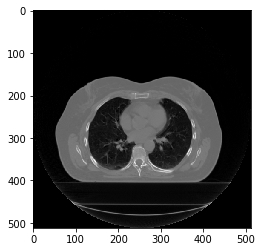

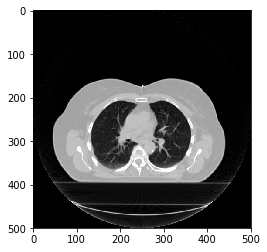

In [30]:
#Show an example image
INPUT_FOLDER = 'example_dcm_sample/'
slice_example = load_scan("example_dcm_sample/ANON_LUNG_TC001/CT")
slice_example_pixels = get_pixels_hu(slice_example)
#normalized_example_pixels = normalize(slice_example_pixels)
resample_example_pixels, spacing = resample(slice_example_pixels, slice_example, [1,1,1])
#Seems that some resampled images are not clear enough, so we skip this step at this moment.
normalized_example_pixels = normalize(resample_example_pixels)
plt.imshow(slice_example_pixels[50], cmap=plt.cm.gray)    #raw images
plt.show()
#plt.imshow(resample_example_pixels[50], cmap=plt.cm.gray) #resampled images
#plt.show()
plt.imshow(normalized_example_pixels[151], cmap=plt.cm.gray) #normalized images
plt.show()
# Each slice is a 512*512 image, in total 144 slices have been found in the No.144 sample
#normalized_example_pixels.shape
#If resampling, we will see 360 slices for this image.

In [ ]:
def process(patientID, label, rsp=False):
    patient = load_scan(patientID)
    slices = get_pixels_hu(patient)
    if rsp:
        slices,spacing = resample(slices, patient, [1,1,1])
    tri_slices = _3D_images_resize(triplicate(normalize(slices)),224,224)

    # for slice in slices:
    #     slice = triplicate(normalize(imresize(slice, (224, 224))))
    reset_default_graph()
    gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
    imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16(imgs, '/home/yunxiao/VGG/vgg16_weights.npz', sess)
    bottle_neck = sess.run(vgg.bn, feed_dict={vgg.imgs: tri_slices})
    del slices, tri_slices, sess, vgg,imgs
    

    if label == 1:
        label = np.array([0, 1])
    elif label == 0:
        label = np.array([1, 0])

    return bottle_neck, label



INPUT_FOLDER = '/labs/colab/3DDD/kaggle_data/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
labels = pd.read_csv('/labs/colab/3DDD/kaggle_data/stage1_labels.csv', index_col=0)
sample_data = []

for num, patientID in enumerate(patients):
    try:
        label = labels.get_value(patientID, 'cancer')
        rnnInput,label = process(INPUT_FOLDER + patientID, label, rsp=True)
        sample_data.append( (rnnInput,label) )
        print 'Patient',num,'processed.'
    except KeyError as err:
        print 'Unlabeled patient:', num, "passed."

        
np.save('sample_data.npy', sample_data) #save bottle neck data from pre-trained network
print 'pre-processed data saved.'

After the preprocessing steps, we obtain a 4 dimensional numpy tensor structure to represent the 3-D image for one individual. Then we use the pre-trained network to generate bottle-neck features prior to the RNN training.

# Traning with Recurrent Neural Network

The data output from the intimediate step have a 3D tensor structure: n_samples * n_slices * 4096 for iamges

In [2]:
import numpy as np
import tensorflow as tf


seq_max_len = 200 # Sequence max length
n_classes = 2 # linear sequence or not
n_features = 4096


def data_summary(data):
    summary = dict()
    summary["len"] = len(data)
    summary["n_slices"] = np.array(list(map(lambda x: len(x[0]), data)))
    summary["n_features"] = n_features
    summary["max_seq_len"] = summary["n_slice"].max()
    summary["cancer"] = np.array(list(map(lambda x: x[1][1], data)))
    
    return summary

class DataBatchGenerator(object):
    """ 
    This class generate samples for training and testing (random sampling with a given proportion):
    - Class 0: normal samples
    - Class 1: cancer samples
    NOTICE:
    We have to pad each sequence to reach 'max_seq_len' for TensorFlow
    consistency (we cannot feed a numpy array with inconsistent
    dimensions). The dynamic calculation will then be perform thanks to
    'seqlen' attribute that records every actual sequence length.
    """
    def __init__(self, data, summary, test_prop = 0.1):
        self.images = []
        self.labels = []
        self.seqlen = summary["n_slices"]
        max_seq_len = summary["max_seq_len"]
        for i in range(summary["len"]):
            self.images.append(np.stack(data[i][0],np.zeros([max_seq_len-self.seqlen[i],n_features])))
            #pad each sequence to reach 'max_seq_len'
            self.labels.append(data[i][1])
        #Obtain the training set and test set for RNN
        self.test = np.random.choice(summary["len"],round(test_prop*summary["len"]), replace = False)
        self.train =  np.setdiff1d(np.array(range(summary["len"])), self.test)


    def next_train(self, batch_size):
        """ Return a batch of data for training.
        """
        len_train = len(self.train)
        batch_id = np.random.choice(len_train, batch_size, replace=False)
        batch_images = []
        batch_labels = []
        batch_seqlen = []
        for i in batch_id:
            idx = self.train[i]
            batch_images.append(self.images[idx])
            batch_labels.append(self.labels[idx])
            batch_seqlen.append(self.seqlen[idx])
            
        return batch_data, batch_labels, batch_seqlen
    
    
    def get_test(self):
        """Return the selected test dataset.
        """
        test_images = []
        test_labels = []
        test_seqlen = []
        for i in self.test:
            test_images.append(self.images[i])
            test_labels.append(self.labels[i])
            test_seqlen.append(self.seqlen[i])
        
        return test_images, test_labels, test_seqlen



In [ ]:
# ==========
#   MODEL
# ==========

# Parameters
learning_rate = 0.01
training_iters = 1000000
batch_size = 128
display_step = 100
n_embedding = 1000
n_hidden = 128 # hidden layer num of features
# Network Parameters
bottle_neck_data = np.load("sample_data.npy")
bottle_neck_summary = data_summary(bottle_neck_data)
dataset = DataBatchGenerator(bottle_neck_data,bottle_neck_summary,0.10)


# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, n_features])
y = tf.placeholder("float", [None, n_classes])

# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None])

# Define weights
weights = {
    'in': tf.Variable(tf.random_normal([n_features, n_embedding])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'in':tf.Variable(tf.random_normal([n_embedding])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}



In [ ]:
def dynamicRNN(x, seqlen, weights, biases):
    #use LSTM
    x = tf.unstack(x, seq_max_len, 1)
    x_embedding = list(map(lambda ts: tf.matmul(ts, weights['in']) + biases['in'], x ))
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x_embedding, dtype=tf.float32,
                                sequence_length=seqlen)
    outputs = tf.stack(outputs)
    outputs = tf.transpose(outputs, [1, 0, 2])
    batch_size = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size) * seq_max_len + (seqlen - 1)
    # Indexing
    outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)
    # Linear activation, using outputs computed above
    return tf.matmul(outputs, weights['out']) + biases['out']


pred = dynamicRNN(x, seqlen, weights, biases)
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
all_variable = tf.trainable_variables() # all vars of your graph
cost += tf.contrib.layers.apply_regularization(l1_regularizer, all_variable) #use L1 penalty

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session(config = tf.ConfigProto(device_count = {'GPU':0})) as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen = trainset.next_train(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       seqlen: batch_seqlen})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y,
                                                seqlen: batch_seqlen})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y,
                                             seqlen: batch_seqlen})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy
    test_image, test_label, test_seqlen = dataset.get_test()
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_image, y: test_label,
                                      seqlen: test_seqlen}))